# **Задание**

**Распознавание рукописного ввода на примере базы MNIST**

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

In [ ]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [ ]:
train[:, 1]

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [7., 0., 0., ..., 0., 0., 0.],
       [6., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.]])

In [ ]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
train.shape, test.shape

((42000, 785), (28000, 784))

In [ ]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [ ]:
train_label.shape

(42000,)

In [ ]:
train_img.shape, test_img.shape

((42000, 28, 28), (28000, 28, 28))

Визуализация исходных данных

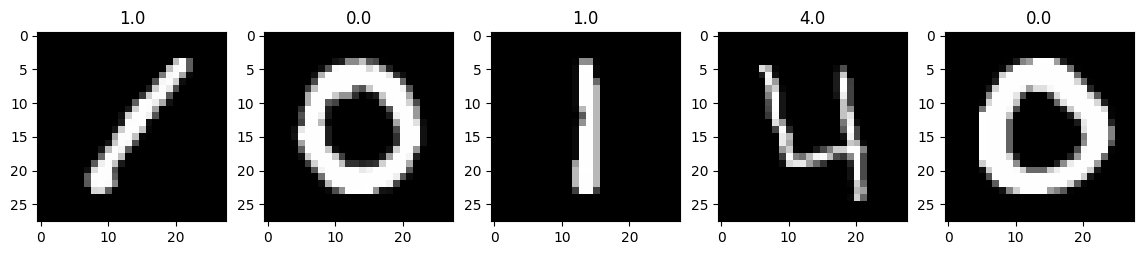

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

Выделение признаков изображений с помощью гистограммы градиентов.

In [ ]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (14,14)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,
                        blockSize,
                        blockStride,
                        cellSize,
                        nbins,
                        derivAperture,
                        winSigma,
                        histogramNormType,
                        L2HysThreshold,
                        gammaCorrection,
                        nlevels)

In [ ]:
# Список с дескрипторами для обучающей выборки
train_d = np.zeros((len(train_img), 144))
for i in range(len(train_img)):
    descriptor = hog.compute(np.uint8(train_img[i]))
    #hist, borders = np.histogram(train_theta[i], bins=16, range=(0., 2. * np.pi), weights=train_g[i])
    train_d[i] = descriptor

In [ ]:
# Список с дескрипторами для тестовой выборки
test_d = np.zeros((len(test_img), 144))
for i in range(len(test_img)):
    descriptor = hog.compute(np.uint8(test_img[i]))
    #hist, borders = np.histogram(test_theta[i], bins=16, range=(0., 2. * np.pi), weights=test_g[i])
    test_d[i] = descriptor

In [ ]:
# Нормирование значений
x_train = train_d / np.linalg.norm(train_d, axis=1)[:, None]

In [ ]:
x_test = test_d / np.linalg.norm(test_d, axis=1)[:, None]

In [ ]:
x_train.shape, x_test.shape

((42000, 144), (28000, 144))

Разбивка на выборки для обучения и валидации.

In [ ]:
from sklearn.model_selection import train_test_split

y_train, y_val, x_train, x_val = train_test_split(
    train_label, x_train, test_size=0.2,
    random_state=42)

In [ ]:
y_train.shape, y_val.shape

((33600,), (8400,))

Обучение классификатора (метод k-ближайших соседей) на обучающей выборке.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model = KNeighborsClassifier()

In [ ]:
model.fit(x_train, y_train)

KNeighborsClassifier()

Предсказание и оценка метрики на выборке для валидации.

In [ ]:
prediction = model.predict(x_val)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, prediction)

0.9696428571428571

Предсказания на тестовой выборке:

In [ ]:
test_prediction = model.predict(x_test).astype(int)

In [ ]:
test_prediction.shape

(28000,)

Файл с предсказаниями на тестовой выборке для отправки на kaggle:

In [ ]:
with open('submit_SLV.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(test_prediction, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
!head submit_SLV.csv

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


**Public score 0,9701.**